## Hybrid Solver with Measurable VQLS

Successfully created MOCK noise model (local_mock_model).
--- Using NOISY AerEstimator (Density Matrix) with local_mock_model noise. ---
--- Running simulation... ---
--- Starting Hybrid Classical/VQLS Simulation ---
Classical simulation (N=32) finished.
--- VQLS setup complete. Starting simulation loop. ---

--- Hybrid Step 1/100 ---
Starting optimizer...
Optimizer finished in 5.23s. Final cost: 7.8214e-03
Step 1 took 5.28 seconds.

--- Hybrid Step 2/100 ---
Starting optimizer...
Optimizer finished in 5.70s. Final cost: 1.4597e-03
Step 2 took 5.77 seconds.

--- Hybrid Step 3/100 ---
Starting optimizer...
Optimizer finished in 5.26s. Final cost: 8.7125e-04
Step 3 took 5.33 seconds.

--- Hybrid Step 4/100 ---
Starting optimizer...
Optimizer finished in 5.15s. Final cost: 4.0608e-04
Step 4 took 5.21 seconds.

--- Hybrid Step 5/100 ---
Starting optimizer...
Optimizer finished in 5.31s. Final cost: 1.5877e-04
Step 5 took 5.38 seconds.

--- Hybrid Step 6/100 ---
Starting optimizer...
Optimi

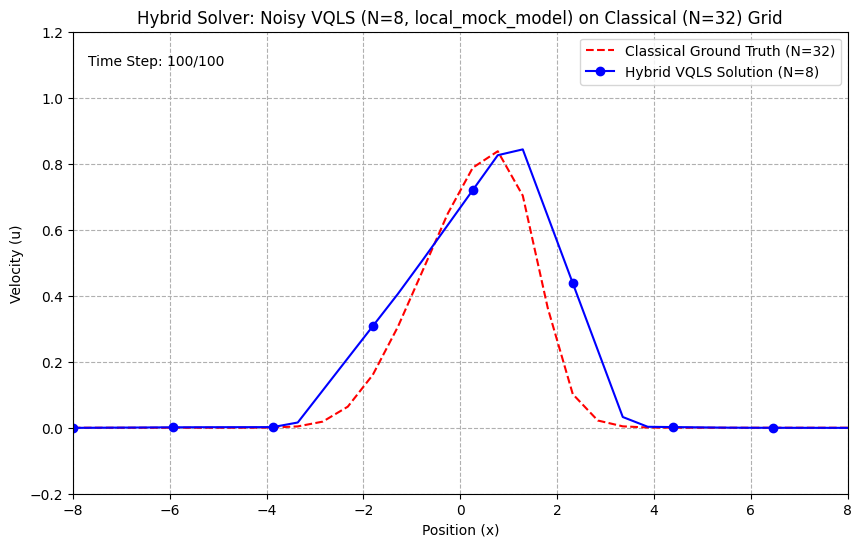

--- Simulation complete. ---


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.optimize import minimize
import time

# --- QISKIT IMPORTS ---
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit_aer import AerSimulator
from qiskit.visualization import *
import math

# --- LOCAL AER ESTIMATOR IMPORT ---
from qiskit_aer.primitives import Estimator as AerEstimator

# --- LOCAL NOISE MODEL IMPORTS ---
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error
from qiskit.circuit.library import EfficientSU2


# --- NOISE MODEL ACQUISITION ---
REAL_NOISE_MODEL = None
NOISE_BACKEND_NAME = 'ibm_lagos_mock'

try:
    from qiskit_ibm_provider import IBMProvider
    provider = IBMProvider(instance='ibm-q/open/main')
    NOISE_BACKEND_NAME = 'ibm_lagos'
    REAL_NOISE_MODEL = NoiseModel.from_backend(provider.get_backend(NOISE_BACKEND_NAME))
    print(f"Successfully loaded REAL noise model from {NOISE_BACKEND_NAME}.")

except Exception as e:
    print(f"Warning: Could not load real noise model. Creating local mock noise model. Error: {e}")
    
    t1_time = 40.0e3
    t2_time = 60.0e3
    time_cx = 300.0
    time_sx = 50.0
    
    mock_noise_model = NoiseModel()
    mock_noise_model.add_basis_gates(['rz', 'sx', 'cx', 'id'])

    n_qubits_sim = 3
    for i in range(n_qubits_sim):
        relax_sx = thermal_relaxation_error(t1_time, t2_time, time_sx)
        mock_noise_model.add_quantum_error(relax_sx, ['sx'], [i])
    
    relax_cx = thermal_relaxation_error(t1_time, t2_time, time_cx).expand(
                 thermal_relaxation_error(t1_time, t2_time, time_cx))
    
    mock_noise_model.add_quantum_error(relax_cx, ['cx'], [0, 1])
    mock_noise_model.add_quantum_error(relax_cx, ['cx'], [1, 2])
    mock_noise_model.add_quantum_error(relax_cx, ['cx'], [2, 0]) 
    
    error_1q = depolarizing_error(0.001, 1) 
    mock_noise_model.add_all_qubit_quantum_error(error_1q, ['sx', 'rz'])
    
    REAL_NOISE_MODEL = mock_noise_model
    NOISE_BACKEND_NAME = 'local_mock_model'
    print(f"Successfully created MOCK noise model ({NOISE_BACKEND_NAME}).")


def build_A(N, nu, dt, h):
    alpha = nu * dt / (h**2)
    diag = np.ones(N) * (1 + 2*alpha)
    off = np.ones(N-1) * (-alpha)
    A = np.diag(diag) + np.diag(off, 1) + np.diag(off, -1)
    return A

def advect_upwind(u, dt, h):
    N = len(u)
    ustar = u.copy()
    for i in range(1, N-1):
        dudx = (u[i] - u[i-1]) / h
        ustar[i] = u[i] - dt * u[i] * dudx
    ustar[0] = 0.0
    ustar[-1] = 0.0
    return ustar

def pad_to_power_of_two(vec):
    N_orig = len(vec)
    target_N = 1 << int(np.ceil(np.log2(N_orig)))
    dtype = np.float64 if np.isrealobj(vec) else np.complex128
    if N_orig == target_N:
        return vec.astype(dtype), target_N
    padded = np.zeros(target_N, dtype=dtype)
    padded[:N_orig] = vec
    return padded, target_N

def unitary_from_state(vec):
    vec = np.asarray(vec, dtype=np.complex128).reshape(-1)
    norm = np.linalg.norm(vec)
    if norm < 1e-12:
        raise ValueError("Cannot build unitary from near-zero vector.")
    v0 = vec / norm
    dim = v0.size
    M = np.random.randn(dim, dim) + 1j * np.random.randn(dim, dim)
    M[:, 0] = v0
    Q, R = np.linalg.qr(M)
    phase = np.vdot(Q[:, 0], v0)
    if np.abs(phase) > 1e-12:
        Q = Q * (phase.conjugate() / np.abs(phase))
    Q[:, 0] = v0
    return Q

class VQLS_Measurable:
    def __init__(self, A_matrix, b_vector, n_qubits, reps=3):
        # print("Initializing VQLS_Measurable...")
        self.n_qubits = int(n_qubits)
        self.reps = int(reps)
        self.N_orig = A_matrix.shape[0]

        if 2**self.n_qubits < self.N_orig:
            raise ValueError(f"Not enough qubits ({self.n_qubits}) for matrix size {self.N_orig}.")

        b_norm = np.linalg.norm(b_vector)
        if b_norm < 1e-9:
            raise ValueError("b_vector is near-zero.")
        self.b_sv = b_vector / b_norm
        self.b_sv_padded, self.N_padded = pad_to_power_of_two(self.b_sv)

        if self.N_padded != 2**self.n_qubits:
            raise ValueError(f"Padded size {self.N_padded} != 2**{self.n_qubits}")

        U_b = unitary_from_state(self.b_sv_padded)
        self.b_unitary_gate = UnitaryGate(U_b, label="U_b")
        qb_prep = QuantumCircuit(self.n_qubits)
        qb_prep.append(self.b_unitary_gate, range(self.n_qubits))
        self.b_prep_circ = qb_prep.decompose()
        self.b_dag_circ = self.b_prep_circ.inverse()

        A_padded = np.zeros((self.N_padded, self.N_padded), dtype=complex)
        A_padded[:self.N_orig, :self.N_orig] = A_matrix

        self.A_op = SparsePauliOp.from_operator(Operator(A_padded))
        self.A_op_dag = self.A_op.conjugate()
        self.AdagA_op = (self.A_op_dag @ self.A_op).simplify()

        num_ansatz_params = (self.reps + 1) * self.n_qubits * 2
        self.params = ParameterVector('p', num_ansatz_params)
        
        self.ansatz = self.build_ansatz_circuit() 

    def build_ansatz_circuit(self):
        """
        Uses Qiskit's EfficientSU2 (Task B).
        """
        ansatz = EfficientSU2(
            num_qubits=self.n_qubits,
            reps=self.reps,
            entanglement='circular', 
            insert_barriers=True
        )
        
        num_new_params = ansatz.num_parameters
        if num_new_params != len(self.params):
             raise ValueError(f"Parameter vector size mismatch: VQLS expected {len(self.params)}, EfficientSU2 needs {num_new_params}")

        param_mapping = {ansatz.parameters[i]: self.params[i] for i in range(num_new_params)}
        
        return ansatz.assign_parameters(param_mapping).decompose()

    def _build_linear_term_circuit(self):
        qc_linear = QuantumCircuit(self.n_qubits + 1)
        return qc_linear.decompose(), SparsePauliOp("I")

    def cost_quantum(self, param_values, estimator=None, noise_scale=1.0):
        """
        Evaluate C = <x|A^†A|x>_noisy - 2 * Re(<b|A|x>)_ideal + <b|b>
        """
        
        if not isinstance(estimator, AerEstimator):
            bound_ansatz = self.ansatz.assign_parameters(param_values)
            sv = Statevector(bound_ansatz).data
            
            AdagA_mat = self.AdagA_op.to_matrix()
            val_quad = np.real(np.vdot(sv, AdagA_mat @ sv))
            
            A_mat = self.A_op.to_matrix()
            val_linear = np.vdot(self.b_sv_padded.conjugate(), (A_mat @ sv))
            val_linear_real = np.real(val_linear)
            val_const = 1.0
            cost = val_quad - 2.0 * val_linear_real + val_const
            return np.real(cost)

        try:
            circuits_list = [self.ansatz]
            observables_list = [self.AdagA_op]
            param_values_list = [param_values]
            
            job = estimator.run(circuits_list, observables_list, param_values_list) 
            results = job.result()
            val_quad = np.real(results.values[0])
            val_const = 1.0
            
            bound_ansatz_sv = self.ansatz.assign_parameters(param_values)
            sv_ideal = Statevector(bound_ansatz_sv).data
            A_mat = self.A_op.to_matrix()
            val_linear_ideal = np.vdot(self.b_sv_padded.conjugate(), (A_mat @ sv_ideal))
            val_linear_real_ideal = np.real(val_linear_ideal)

            cost = val_quad - 2.0 * val_linear_real_ideal + val_const
            
            return np.real(cost)
        
        except Exception as e:
            print(f"Estimator path failed. Falling back to exact statevector. Error: {e}")
            return self.cost_quantum(param_values, estimator=None)


    def reconstruct_solution(self, params):
        A_unpadded = self.A_op.to_matrix()[:self.N_orig, :self.N_orig].real
        b_unpadded = (self.b_sv * np.linalg.norm(self.b_sv_padded) / np.linalg.norm(self.b_sv))
        b_unpadded = b_unpadded[:self.N_orig].real
        u_classical = np.linalg.solve(A_unpadded, b_unpadded)
        norm_u = np.linalg.norm(u_classical)
        bound_ansatz = self.ansatz.assign_parameters(params)
        sv = Statevector(bound_ansatz).data
        x_sv_scaled = sv * norm_u
        u_rec = x_sv_scaled.real
        return u_rec[:self.N_orig], u_classical

def run_classical_with_history(u_initial, A, max_steps, dt, h):
    history = [u_initial.copy()]
    u_n = u_initial.copy()
    for step in range(max_steps):
        u_star = advect_upwind(u_n.copy(), dt, h)
        u_new = np.linalg.solve(A, u_star)
        u_n = u_new
        history.append(u_n.copy())
    print(f"Classical simulation (N={A.shape[0]}) finished.")
    return history

def run_simulation_loop(estimator):
    """Runs the full hybrid simulation loop with the given estimator."""

    nu = 0.01
    dt = 0.01
    num_frames = 100 

    N_class = 32
    x_grid_class = np.linspace(-8, 8, N_class)
    h_class = x_grid_class[1] - x_grid_class[0]
    u_n_class = np.exp(-x_grid_class**2 / 2)
    A_class = build_A(N_class, nu, dt, h_class)

    N_vqls = 8
    n_qubits = int(np.log2(N_vqls))
    vqls_reps = 4 
    x_grid_vqls = np.linspace(-8, 8, N_vqls)
    h_vqls = x_grid_vqls[1] - x_grid_vqls[0]
    A_vqls = build_A(N_vqls, nu, dt, h_vqls)

    print("--- Starting Hybrid Classical/VQLS Simulation ---")

    classical_history = run_classical_with_history(u_n_class.copy(), A_class, num_frames, dt, h_class)

    vqls_overlay_history = [u_n_class.copy()] 

    n_params = (vqls_reps + 1) * n_qubits * 2
    last_params = 0.1 * np.random.randn(n_params)

    print("--- VQLS setup complete. Starting simulation loop. ---")
    start_time_total = time.time()

    for step in range(num_frames):
        print(f"\n--- Hybrid Step {step+1}/{num_frames} ---")
        step_start_time = time.time()

        u_star_class = advect_upwind(classical_history[step], dt, h_class)
        u_star_vqls = np.interp(x_grid_vqls, x_grid_class, u_star_class)

        if np.linalg.norm(u_star_vqls) > 1e-9:
            vqls = VQLS_Measurable(A_matrix=A_vqls, b_vector=u_star_vqls, n_qubits=n_qubits, reps=vqls_reps)

            objective_fn = lambda p: vqls.cost_quantum(p, estimator=estimator)

            print("Starting optimizer...")
            opt_start_time = time.time()
            res = minimize(objective_fn, last_params, method='COBYLA', options={'maxiter': 200})
            print(f"Optimizer finished in {time.time() - opt_start_time:.2f}s. Final cost: {res.fun:.4e}")

            last_params = res.x

            u_rec, _ = vqls.reconstruct_solution(res.x)
            u_n_overlay = np.interp(x_grid_class, x_grid_vqls, u_rec)
            vqls_overlay_history.append(u_n_overlay)
        else:
            print("Skipping VQLS, b_vector is near-zero.")
            vqls_overlay_history.append(np.zeros_like(u_n_class))

        print(f"Step {step+1} took {time.time() - step_start_time:.2f} seconds.")

    print(f"\n--- Hybrid Simulation Finished in {time.time() - start_time_total:.2f}s ---")
    return classical_history, vqls_overlay_history, x_grid_class, x_grid_vqls, num_frames


# --- MAIN EXECUTION BLOCK ---
if __name__ == "__main__":

    if REAL_NOISE_MODEL:
        noisy_estimator = AerEstimator(
            backend_options={
                'method': 'density_matrix',
                'noise_model': REAL_NOISE_MODEL
            }
        )
        print(f"--- Using NOISY AerEstimator (Density Matrix) with {NOISE_BACKEND_NAME} noise. ---")
    else:
        noisy_estimator = AerEstimator(
            backend_options={'method': 'statevector'}
        )
        print("--- Using local IDEAL AerEstimator (Statevector) as fallback. ---")

    
    print(f"--- Running simulation... ---")
    classical_history, vqls_overlay_history, x_grid_class, x_grid_vqls, num_frames = run_simulation_loop(noisy_estimator)


    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_ylim(-0.2, 1.2)
    ax.set_xlim(-8, 8)
    ax.set_xlabel("Position (x)")
    ax.set_ylabel("Velocity (u)")
    ax.set_title(f"Hybrid Solver: Noisy VQLS (N=8, {NOISE_BACKEND_NAME}) on Classical (N=32) Grid")
    ax.grid(True, linestyle='--')

    line_classical, = ax.plot(x_grid_class, classical_history[0], 'r--', label="Classical Ground Truth (N=32)")
    line_vqls, = ax.plot(x_grid_class, vqls_overlay_history[0], 'bo-', label="Hybrid VQLS Solution (N=8)",
                          markevery=4) 

    ax.legend()
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, va='top')

    def update(frame):
        """Updates both lines for each frame of the animation."""
        if frame < len(classical_history):
            line_classical.set_ydata(classical_history[frame])
        if frame < len(vqls_overlay_history):
            line_vqls.set_ydata(vqls_overlay_history[frame])
        time_text.set_text(f'Time Step: {frame}/{num_frames}')
        return line_classical, line_vqls, time_text

    ani = animation.FuncAnimation(fig, update, frames=num_frames + 1,
                                  blit=True, interval=100)

    print("\nSaving overlay animation... This will take some time.")
    ani.save('hybrid_vqls_noisy_overlay.gif', writer='pillow', fps=10)
    print("Animation saved as hybrid_vqls_noisy_overlay.gif")

    plt.show()

    print("--- Simulation complete. ---")